In [182]:
import logging

logging.basicConfig(
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S'
)

In [2]:
import data
from sklearn.preprocessing import StandardScaler
from torch.nn import MSELoss
from torch.utils.data import DataLoader
from IPython.core.debugger import set_trace
import importlib
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

np.random.seed(42)
torch.set_num_threads(1)

In [3]:
importlib.reload(data)

response_data = data.ExVivoDrugData.load_data()
merge_data = data.MergeData.load_data()

2019-12-01 01:11:24 INFO     Loading drug response data
2019-12-01 01:11:27 INFO     Drug response data loaded
2019-12-01 01:11:27 INFO     Loading merge data
2019-12-01 01:11:28 INFO     Merge data loaded


In [4]:
overlapping_genes = list(set(response_data.X.columns).intersection(merge_data.data.columns))
merge_data.data = merge_data.data[overlapping_genes]
response_data.X = response_data.X[["patient_id"] + response_data.drug_columns + overlapping_genes]

In [5]:
kfold_split = response_data.kfold_patient_split(5)

2019-12-01 01:11:29 INFO     Splitting drug response data into 5 folds
2019-12-01 01:11:36 INFO     Splitting complete


In [6]:
max_patients = 0
drug_with_max_patients = None

for drug_col in response_data.drug_columns:
    genotypes_for_drug = response_data.X[response_data.X[drug_col] == 1]
    genotypes_for_drug = genotypes_for_drug.groupby("patient_id").mean()
    patients_for_drug = genotypes_for_drug.shape[0]
    if patients_for_drug > max_patients:
        max_patients = patients_for_drug
        drug_with_max_patients = drug_col

In [7]:
learning_rate = 5e-7
prior_learning_rate = 5e-7
patience=50

In [8]:
import datetime
import time
from utils import EarlyStopping

criterion = MSELoss()

def train(model):
    
    print("Beginning model training at {}".format(datetime.datetime.now()))
    early_stopping = EarlyStopping(patience=patience)
    test_losses = []
    epoch = 0
    while True:
        start_time = time.time()
        model.train()
        for X_batch, y_batch in train_loader:
            f1_optimizer.zero_grad()
            X_batch = X_batch.float().cuda()
            y_batch = y_batch.float().cuda()
            
            output = model(X_batch)
            loss_train = criterion(output, y_batch)
            
            loss_train.backward()
            f1_optimizer.step()
            
        model.eval()
        for X_batch, y_batch in valid_loader:
            X_batch = X_batch.float().cuda()
            y_batch = y_batch.float().cuda()

            output = model(X_batch)
            loss_valid = criterion(output, y_batch).item()
            end_time = time.time()
            epoch_time = end_time - start_time
        
        if epoch % 10 == 0:
            logging.info("Epoch {} completed in {} secs with valid loss {:.4f}".format(epoch, epoch_time, loss_valid))
            
        early_stopping(loss_valid, model)

        if early_stopping.early_stop:
            print("Early stopping on epoch {}".format(epoch))
            break
        epoch += 1
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.float().cuda()
        y_batch = y_batch.float().cuda()

        output = model(X_batch)
        loss_test = criterion(output, y_batch).item()
    return loss_test

In [9]:
from models import MLP
import torch
from torch import optim

data_loaders = []

for split in kfold_split:

    max_drug_indices_train = split.X_train[drug_with_max_patients] == 1
    max_drug_indices_valid = split.X_valid[drug_with_max_patients] == 1
    max_drug_indices_test = split.X_test[drug_with_max_patients] == 1

    split.X_train = split.X_train[max_drug_indices_train].groupby("patient_id").mean()
    split.X_test = split.X_test[max_drug_indices_test].groupby("patient_id").mean()
    split.X_valid = split.X_valid[max_drug_indices_valid].groupby("patient_id").mean()
    split.y_train = split.y_train[max_drug_indices_train].groupby("patient_id").mean()
    split.y_test = split.y_test[max_drug_indices_test].groupby("patient_id").mean()
    split.y_valid = split.y_valid[max_drug_indices_valid].groupby("patient_id").mean()

    split.X_train.drop(response_data.drug_columns, axis=1, inplace=True)
    split.X_test.drop(response_data.drug_columns, axis=1, inplace=True)
    split.X_valid.drop(response_data.drug_columns, axis=1, inplace=True)
    
    X_train = split.X_train
    y_train = split.y_train

    X_test = split.X_test
    y_test = split.y_test
    
    X_valid = split.X_valid
    y_valid = split.y_valid
    
    feature_scaler = StandardScaler()
    outcome_scaler = StandardScaler()

    logging.info("Fitting feature scalers")
    feature_scaler.fit(X_train[X_train.columns])
    outcome_scaler.fit(y_train[y_train.columns])
    logging.info("Finished fitting feature scalers")

    logging.info("Applying feature scalar")
    X_train[X_train.columns] = feature_scaler.transform(X_train[X_train.columns])
    X_test[X_test.columns] = feature_scaler.transform(X_test[X_test.columns])
    X_valid[X_valid.columns] = feature_scaler.transform(X_valid[X_valid.columns])

    y_train[y_train.columns] = outcome_scaler.transform(y_train[y_train.columns])
    y_test[y_test.columns] = outcome_scaler.transform(y_test[y_test.columns])
    y_valid[y_valid.columns] = outcome_scaler.transform(y_valid[y_valid.columns])
    logging.info("Finished scaling features")
    
    # Create random Tensors to hold inputs and outputs
    train_dataset = data.ExVivoDrugData(X_train, y_train)
    test_dataset = data.ExVivoDrugData(X_test, y_test)
    valid_dataset = data.ExVivoDrugData(X_valid, y_valid)

    batch_size=32
    
    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True
    )

    test_loader = DataLoader(
        dataset=test_dataset,
        batch_size=X_test.shape[0],
        shuffle=False,
        drop_last=False
    )
    
    valid_loader = DataLoader(
        dataset=valid_dataset,
        batch_size=X_valid.shape[0],
        shuffle=False,
        drop_last=False
    )
    
    data_loaders.append((train_loader, test_loader, valid_loader))

2019-12-01 01:11:48 INFO     Fitting feature scalers
2019-12-01 01:11:48 INFO     Finished fitting feature scalers
2019-12-01 01:11:48 INFO     Applying feature scalar
2019-12-01 01:11:48 INFO     Finished scaling features
2019-12-01 01:11:49 INFO     Fitting feature scalers
2019-12-01 01:11:49 INFO     Finished fitting feature scalers
2019-12-01 01:11:49 INFO     Applying feature scalar
2019-12-01 01:11:49 INFO     Finished scaling features
2019-12-01 01:11:49 INFO     Fitting feature scalers
2019-12-01 01:11:49 INFO     Finished fitting feature scalers
2019-12-01 01:11:49 INFO     Applying feature scalar
2019-12-01 01:11:49 INFO     Finished scaling features
2019-12-01 01:11:49 INFO     Fitting feature scalers
2019-12-01 01:11:49 INFO     Finished fitting feature scalers
2019-12-01 01:11:49 INFO     Applying feature scalar
2019-12-01 01:11:50 INFO     Finished scaling features
2019-12-01 01:11:50 INFO     Fitting feature scalers
2019-12-01 01:11:50 INFO     Finished fitting feature s

In [172]:
test_errors_no_prior = []

for train_loader, test_loader, valid_loader in data_loaders:
    D_in, H1, H2, D_out = train_loader.dataset.X.shape[1], 512, 256, 1
    f1_no_prior = MLP(D_in=D_in, H1=H1, H2=H2, D_out=D_out, dropout=0.2).cuda().float()
    f1_optimizer = optim.Adam(f1.parameters(), lr=learning_rate, weight_decay=5e-3)
    
    test_errors_no_prior.append(train(f1_no_prior))

Beginning model training at 2019-12-02 14:10:43.440532


2019-12-02 14:10:43 INFO     Epoch 0 completed in 0.11627769470214844 secs with valid loss 0.9857
2019-12-02 14:10:44 INFO     Epoch 10 completed in 0.08862543106079102 secs with valid loss 0.9857
2019-12-02 14:10:45 INFO     Epoch 20 completed in 0.08932709693908691 secs with valid loss 0.9857
2019-12-02 14:10:46 INFO     Epoch 30 completed in 0.08952498435974121 secs with valid loss 0.9857
2019-12-02 14:10:47 INFO     Epoch 40 completed in 0.08488130569458008 secs with valid loss 0.9857
2019-12-02 14:10:48 INFO     Epoch 50 completed in 0.08810830116271973 secs with valid loss 0.9857


Early stopping on epoch 50
Beginning model training at 2019-12-02 14:10:48.382629


2019-12-02 14:10:48 INFO     Epoch 0 completed in 0.09090113639831543 secs with valid loss 0.8531
2019-12-02 14:10:49 INFO     Epoch 10 completed in 0.08662104606628418 secs with valid loss 0.8531
2019-12-02 14:10:50 INFO     Epoch 20 completed in 0.08577728271484375 secs with valid loss 0.8531
2019-12-02 14:10:51 INFO     Epoch 30 completed in 0.08415079116821289 secs with valid loss 0.8531
2019-12-02 14:10:52 INFO     Epoch 40 completed in 0.08464336395263672 secs with valid loss 0.8531
2019-12-02 14:10:53 INFO     Epoch 50 completed in 0.09273362159729004 secs with valid loss 0.8531


Early stopping on epoch 50
Beginning model training at 2019-12-02 14:10:53.289465


2019-12-02 14:10:53 INFO     Epoch 0 completed in 0.09167170524597168 secs with valid loss 1.1071
2019-12-02 14:10:54 INFO     Epoch 10 completed in 0.09048223495483398 secs with valid loss 1.1071
2019-12-02 14:10:55 INFO     Epoch 20 completed in 0.09126901626586914 secs with valid loss 1.1071
2019-12-02 14:10:56 INFO     Epoch 30 completed in 0.09282803535461426 secs with valid loss 1.1071
2019-12-02 14:10:57 INFO     Epoch 40 completed in 0.09240579605102539 secs with valid loss 1.1071
2019-12-02 14:10:58 INFO     Epoch 50 completed in 0.08465170860290527 secs with valid loss 1.1071


Early stopping on epoch 50
Beginning model training at 2019-12-02 14:10:58.316933


2019-12-02 14:10:58 INFO     Epoch 0 completed in 0.0932774543762207 secs with valid loss 0.7721
2019-12-02 14:10:59 INFO     Epoch 10 completed in 0.08820772171020508 secs with valid loss 0.7721
2019-12-02 14:11:00 INFO     Epoch 20 completed in 0.08530807495117188 secs with valid loss 0.7721
2019-12-02 14:11:01 INFO     Epoch 30 completed in 0.08746218681335449 secs with valid loss 0.7721
2019-12-02 14:11:02 INFO     Epoch 40 completed in 0.08920598030090332 secs with valid loss 0.7721
2019-12-02 14:11:03 INFO     Epoch 50 completed in 0.09136700630187988 secs with valid loss 0.7721


Early stopping on epoch 50
Beginning model training at 2019-12-02 14:11:03.203884


2019-12-02 14:11:03 INFO     Epoch 0 completed in 0.08957481384277344 secs with valid loss 1.1777
2019-12-02 14:11:04 INFO     Epoch 10 completed in 0.08939599990844727 secs with valid loss 1.1777
2019-12-02 14:11:05 INFO     Epoch 20 completed in 0.08785033226013184 secs with valid loss 1.1777
2019-12-02 14:11:06 INFO     Epoch 30 completed in 0.08786749839782715 secs with valid loss 1.1777
2019-12-02 14:11:07 INFO     Epoch 40 completed in 0.08689165115356445 secs with valid loss 1.1777
2019-12-02 14:11:08 INFO     Epoch 50 completed in 0.0899343490600586 secs with valid loss 1.1777


Early stopping on epoch 50


In [11]:
import egexplainer
import importlib

importlib.reload(egexplainer)

APExp = egexplainer.VariableBatchExplainer(train_dataset)

In [412]:
from models import LinearModel

def train_with_learned_prior(f1, f2, prior_info):
    
    print("Beginning model training at {}".format(datetime.datetime.now()))
    early_stopping = EarlyStopping(patience=patience)
    test_losses = []
    epoch = 0
    while True:
        start_time = time.time()
        f1.train()
        for X_batch, y_batch in train_loader:
            f1_optimizer.zero_grad()
            f2_optimizer.zero_grad()
            
            X_batch = X_batch.float().cuda()
            y_batch = y_batch.float().cuda()
            
            output = f1(X_batch)
            
            eg = APExp.shap_values(f1, X_batch).abs()
            prior_differences = f2(prior_info).squeeze()
            prior_loss = ((prior_differences - eg)**2).mean()
            
            loss_train = criterion(output, y_batch) + prior_loss
            
            loss_train.backward()
            f1_optimizer.step()
            f2_optimizer.step()
            
        f1.eval()
        for X_batch, y_batch in valid_loader:
            X_batch = X_batch.float().cuda()
            y_batch = y_batch.float().cuda()

            output = f1(X_batch)
            loss_valid = criterion(output, y_batch).item()
            end_time = time.time()
            epoch_time = end_time - start_time
        
        if epoch % 10 == 0:
            logging.info("Epoch {} completed in {} secs with valid loss {:.4f}".format(epoch, epoch_time, loss_valid))
        
        early_stopping(loss_valid, [f1, f2])

        if early_stopping.early_stop:
            print("Early stopping on epoch {}".format(epoch))
            break
        epoch += 1
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.float().cuda()
        y_batch = y_batch.float().cuda()

        output = f1(X_batch)
        loss_test = criterion(output, y_batch).item()
    return loss_test

In [413]:
test_errors_with_prior = []
prior_info = merge_data.data.T
prior_info = torch.FloatTensor(prior_info.values).cuda()
prior_mlp_errors = []


for train_loader, test_loader, valid_loader in data_loaders:
    D_in, H1, H2, D_out = X_train.shape[1], 512, 256, 1
    f1 = MLP(D_in=D_in, H1=H1, H2=H2, D_out=D_out, dropout=0.2).cuda().float()
    f1_optimizer = optim.Adam(f1.parameters(), lr=learning_rate)
    
    f2 = MLP(
        D_in = prior_info.shape[1],
        H1 = 5,
        H2 = 3,
        D_out = 1,
        dropout = 0.0
    ).cuda().float()

    f2_optimizer = optim.Adam(f2.parameters(), lr=prior_learning_rate)

    test_errors_with_prior.append(train_with_learned_prior(f1, f2, prior_info))

Beginning model training at 2019-12-03 13:05:25.196023


2019-12-03 13:05:25 INFO     Epoch 0 completed in 0.22510147094726562 secs with valid loss 0.9745
2019-12-03 13:05:30 INFO     Epoch 10 completed in 0.1982252597808838 secs with valid loss 0.9446
2019-12-03 13:05:34 INFO     Epoch 20 completed in 0.19881796836853027 secs with valid loss 0.9202
2019-12-03 13:05:39 INFO     Epoch 30 completed in 0.19471049308776855 secs with valid loss 0.8997
2019-12-03 13:05:44 INFO     Epoch 40 completed in 0.19327950477600098 secs with valid loss 0.8813
2019-12-03 13:05:49 INFO     Epoch 50 completed in 0.19730305671691895 secs with valid loss 0.8624
2019-12-03 13:05:54 INFO     Epoch 60 completed in 0.18996191024780273 secs with valid loss 0.8442
2019-12-03 13:05:58 INFO     Epoch 70 completed in 0.20136094093322754 secs with valid loss 0.8265
2019-12-03 13:06:03 INFO     Epoch 80 completed in 0.191023588180542 secs with valid loss 0.8086
2019-12-03 13:06:08 INFO     Epoch 90 completed in 0.19816374778747559 secs with valid loss 0.7922
2019-12-03 13:

Early stopping on epoch 702
Beginning model training at 2019-12-03 13:10:03.248574


2019-12-03 13:10:03 INFO     Epoch 0 completed in 0.19463276863098145 secs with valid loss 0.8584
2019-12-03 13:10:08 INFO     Epoch 10 completed in 0.1936814785003662 secs with valid loss 0.8092
2019-12-03 13:10:12 INFO     Epoch 20 completed in 0.2009139060974121 secs with valid loss 0.7728
2019-12-03 13:10:17 INFO     Epoch 30 completed in 0.19837594032287598 secs with valid loss 0.7427
2019-12-03 13:10:22 INFO     Epoch 40 completed in 0.21020174026489258 secs with valid loss 0.7187
2019-12-03 13:10:27 INFO     Epoch 50 completed in 0.19393467903137207 secs with valid loss 0.6987
2019-12-03 13:10:32 INFO     Epoch 60 completed in 0.19818782806396484 secs with valid loss 0.6811
2019-12-03 13:10:36 INFO     Epoch 70 completed in 0.20003247261047363 secs with valid loss 0.6655
2019-12-03 13:10:41 INFO     Epoch 80 completed in 0.19702839851379395 secs with valid loss 0.6505
2019-12-03 13:10:46 INFO     Epoch 90 completed in 0.19553375244140625 secs with valid loss 0.6379
2019-12-03 13

Early stopping on epoch 825
Beginning model training at 2019-12-03 13:15:30.057743


2019-12-03 13:15:30 INFO     Epoch 0 completed in 0.20621752738952637 secs with valid loss 1.1047
2019-12-03 13:15:35 INFO     Epoch 10 completed in 0.19640421867370605 secs with valid loss 1.0698
2019-12-03 13:15:40 INFO     Epoch 20 completed in 0.18925046920776367 secs with valid loss 1.0444
2019-12-03 13:15:45 INFO     Epoch 30 completed in 0.1952192783355713 secs with valid loss 1.0247
2019-12-03 13:15:49 INFO     Epoch 40 completed in 0.20696377754211426 secs with valid loss 1.0098
2019-12-03 13:15:54 INFO     Epoch 50 completed in 0.20348215103149414 secs with valid loss 0.9964
2019-12-03 13:15:59 INFO     Epoch 60 completed in 0.20120501518249512 secs with valid loss 0.9865
2019-12-03 13:16:04 INFO     Epoch 70 completed in 0.20335102081298828 secs with valid loss 0.9768
2019-12-03 13:16:09 INFO     Epoch 80 completed in 0.19251537322998047 secs with valid loss 0.9653
2019-12-03 13:16:13 INFO     Epoch 90 completed in 0.20269250869750977 secs with valid loss 0.9561
2019-12-03 1

Early stopping on epoch 638
Beginning model training at 2019-12-03 13:19:55.369879


2019-12-03 13:19:55 INFO     Epoch 0 completed in 0.19150805473327637 secs with valid loss 0.8092
2019-12-03 13:20:53 INFO     Epoch 10 completed in 0.1941080093383789 secs with valid loss 0.7835
2019-12-03 13:20:59 INFO     Epoch 20 completed in 0.19303154945373535 secs with valid loss 0.7678
2019-12-03 13:21:04 INFO     Epoch 30 completed in 0.19783806800842285 secs with valid loss 0.7551
2019-12-03 13:21:09 INFO     Epoch 40 completed in 0.1996173858642578 secs with valid loss 0.7484
2019-12-03 13:21:13 INFO     Epoch 50 completed in 0.19666671752929688 secs with valid loss 0.7465
2019-12-03 13:21:16 INFO     Epoch 60 completed in 0.18480443954467773 secs with valid loss 0.7471
2019-12-03 13:21:17 INFO     Epoch 70 completed in 0.18506836891174316 secs with valid loss 0.7488
2019-12-03 13:21:19 INFO     Epoch 80 completed in 0.18649983406066895 secs with valid loss 0.7526
2019-12-03 13:21:21 INFO     Epoch 90 completed in 0.18480277061462402 secs with valid loss 0.7549
2019-12-03 13

Early stopping on epoch 100
Beginning model training at 2019-12-03 13:21:23.669600


2019-12-03 13:21:23 INFO     Epoch 0 completed in 0.18554353713989258 secs with valid loss 1.1268
2019-12-03 13:21:29 INFO     Epoch 10 completed in 0.19305920600891113 secs with valid loss 1.0379
2019-12-03 13:21:34 INFO     Epoch 20 completed in 0.19323158264160156 secs with valid loss 0.9713
2019-12-03 13:21:39 INFO     Epoch 30 completed in 0.1970663070678711 secs with valid loss 0.9198
2019-12-03 13:21:43 INFO     Epoch 40 completed in 0.1897580623626709 secs with valid loss 0.8798
2019-12-03 13:21:49 INFO     Epoch 50 completed in 0.19344520568847656 secs with valid loss 0.8469
2019-12-03 13:21:54 INFO     Epoch 60 completed in 0.19225811958312988 secs with valid loss 0.8169
2019-12-03 13:21:59 INFO     Epoch 70 completed in 0.19209837913513184 secs with valid loss 0.7917
2019-12-03 13:22:04 INFO     Epoch 80 completed in 0.17953133583068848 secs with valid loss 0.7708
2019-12-03 13:22:09 INFO     Epoch 90 completed in 0.19034123420715332 secs with valid loss 0.7545
2019-12-03 13

Early stopping on epoch 487


In [136]:
from data import BasicDataset

prior_data = BasicDataset(X = prior_info, y = np.zeros(prior_info.shape[0]))

meta_APExp = egexplainer.VariableBatchExplainer(prior_data)

In [394]:
test_loader = data_loaders[4][1]
for X_batch, y_batch in test_loader:
    y_batch = y_batch.squeeze()
    X_batch = X_batch.float().cuda()
    y_batch = y_batch.float().cuda()
    predicted_attributions = f2(prior_info).abs().squeeze().cpu().detach().numpy()
    meta_eg = meta_APExp.shap_values(f2, prior_info).abs().cpu().detach().numpy()  
    predicted_attributions_random_prior = f2_random(prior_info).abs().squeeze().cpu().detach().numpy()

In [ ]:
meta_eg = np.abs(meta_eg)
row_sums = meta_eg.sum(axis=1)
meta_eg = meta_eg / row_sums[:, np.newaxis]
meta_eg = (meta_eg.T * predicted_attributions).T
df = pd.DataFrame(data={
    "Mutation": meta_eg[:,0],
    "Hubness": meta_eg[:,1],
    "Regulator": meta_eg[:,2],
    "CNV": meta_eg[:,3],
    "Methylation": meta_eg[:,4],
    "total_attribution": predicted_attributions,
    "y":merge_data.data.columns
})

num_bars = 200
data_to_plot = df.dropna().nlargest(num_bars, "total_attribution")

data_to_plot = data_to_plot.sort_values(by="total_attribution", ascending=True)
data_to_plot.drop("total_attribution", axis=1, inplace=True)
data_to_plot.set_index("y", inplace=True)

import seaborn as sns
sns.set_style("darkgrid")
sns.set_context({"figure.figsize": (24, 10)})

colors = {
    "mutation": "red",
    "hubness": "#0000A3",
    "regulator": "#008000",
    "cnv": "#00CED1",
    "methylation": "#8A2BE2"
}

mutation_bar = plt.Rectangle((0,0),1,1,fc=colors["mutation"], edgecolor = 'none')
hubness_bar = plt.Rectangle((0,0),1,1,fc=colors["hubness"],  edgecolor = 'none')
regulator_bar = plt.Rectangle((0,0),1,1,fc=colors["regulator"],  edgecolor = 'none')
cnv_bar = plt.Rectangle((0,0),1,1,fc=colors["cnv"], edgecolor = 'none')
methylation_bar = plt.Rectangle((0,0),1,1,fc=colors["methylation"],edgecolor = 'none')

data_to_plot.plot(
    kind="barh",
    stacked=True,
    color=[
        colors["mutation"],
        colors["hubness"],
        colors["regulator"],
        colors["cnv"],
        colors["methylation"]
    ],
    figsize=(48,24),
    width=0.8,
    legend=None
)

plt.xticks(fontsize=24)
plt.yticks(fontsize=24)

#plt.legend(
#    [mutation_bar, hubness_bar, regulator_bar, cnv_bar, methylation_bar],
#    ['Mutation', 'Hubness', "Regulator", "CNV", "Methylation"],
#    ncol = 1,
#    prop={'size':24}
#)

plt.xlabel("Predicted Gene Importance", fontsize=24)

fig = plt.gcf()
fig.set_size_inches(15.5, 10.5)
plt.tight_layout()

In [23]:
from sklearn import linear_model

potential_alphas = np.linspace(start=0, stop=1, num=100)[1:]
lasso_errors = []

best_mse_sum = float("inf")
best_alpha = None
for alpha in potential_alphas:
    mse_sum = 0
    for train_loader, test_loader, valid_loader in data_loaders:
        clf = linear_model.Lasso(alpha=alpha)
        clf.fit(train_loader.dataset.X, train_loader.dataset.y)
        predictions = clf.predict(valid_loader.dataset.X)
        mse = ((predictions - valid_loader.dataset.y.values)**2).mean()
        mse_sum += mse
    if mse_sum < best_mse_sum:
        best_alpha = alpha
        best_mse_sum = mse_sum

In [24]:
test_lasso_errors = []

for train_loader, test_loader, valid_loader in data_loaders:
    clf = linear_model.Lasso(alpha=alpha)
    clf.fit(train_loader.dataset.X, train_loader.dataset.y)
    predictions = clf.predict(test_loader.dataset.X)
    mse = ((predictions - test_loader.dataset.y.values)**2).mean()
    test_lasso_errors.append(mse)

(0, 1.159420074513051)

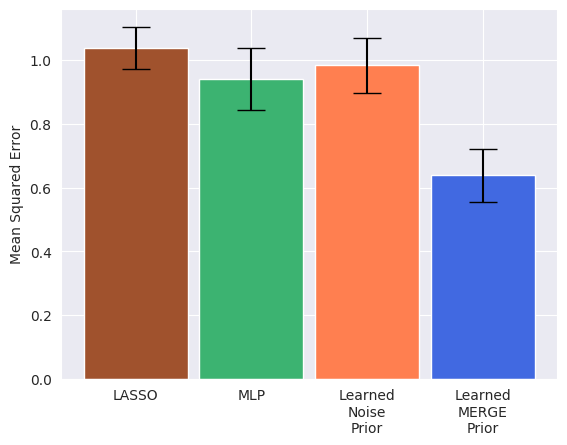

In [82]:
from scipy.stats import sem
import matplotlib as mpl

import seaborn as sns
sns.set_style("darkgrid")

test_errors_with_prior = np.array(test_errors_with_prior)
test_errors_no_prior = np.array(test_errors_no_prior)
test_lasso_errors = np.array(test_lasso_errors)
test_errors_random_prior = np.array(test_errors_random_prior)

mean_errors = [
    test_lasso_errors.mean(),
    test_errors_no_prior.mean(),
    test_errors_random_prior.mean(),
    test_errors_with_prior.mean()
]

stderr = [
    sem(test_lasso_errors),
    sem(test_errors_no_prior),
    sem(test_errors_random_prior),
    sem(test_errors_with_prior)
]

df = pd.DataFrame()

plt.bar(
    ["LASSO", "MLP", "Learned\nNoise\nPrior", "Learned\nMERGE\nPrior"],
    mean_errors,
    yerr = stderr,
    align='center',
    ecolor='black',
    capsize=10,
    color=['sienna', 'mediumseagreen', 'coral', 'royalblue'],
    width=0.9
)
plt.ylabel("Mean Squared Error")

plt.xticks(fontsize=10)
plt.ylim(0)

In [ ]:
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

fig, ax = plt.subplots()
ax.scatter(x=1/test_errors_no_prior, y=1/test_errors_with_prior, c='black')
line = mlines.Line2D([0, 1], [0, 1], color='red')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)
plt.xlim(0, 5.0)
plt.ylim(0, 5.0)
plt.xlabel("MLP Performance (1/MSE)")
plt.ylabel("MLP w/ Prior Performance (1/MSE)")
plt.title("MLP w/ Prior Performance vs. MLP (no prior)")
plt.show()

In [78]:
print(test_errors_with_prior)

[0.4851329  0.4434762  0.86726624 0.79576236 0.60095805]


In [79]:
print(test_errors_no_prior)

[1.17932308 0.79460359 0.76972598 0.78498805 1.17331934]


In [388]:
print(test_errors_random_prior)

[1.20448315 0.83596438 0.75235468 0.98300868 1.13965034]


In [393]:
test_errors_random_prior = []
genes = merge_data.data.T.index

mu = 0
sigma = 1

prior_info = pd.DataFrame(np.random.normal(mu, sigma, merge_data.data.T.shape))
prior_info = prior_info.set_index(genes)
prior_info = torch.FloatTensor(prior_info.values).cuda()

for train_loader, test_loader, valid_loader in data_loaders:
    D_in, H1, H2, D_out = X_train.shape[1], 512, 256, 1
    f1_random = MLP(D_in=D_in, H1=H1, H2=H2, D_out=D_out, dropout=0.2).cuda().float()
    f1_optimizer = optim.Adam(f1_random.parameters(), lr=learning_rate)
    
    f2_random = MLP(
        D_in = prior_info.shape[1],
        H1 = 5,
        H2 = 3,
        D_out = 1,
        dropout = 0.0
    ).cuda().float()

    f2_optimizer = optim.Adam(f2_random.parameters(), lr=prior_learning_rate)

    test_errors_random_prior.append(train_with_learned_prior(
        f1_random,
        f2_random,
    prior_info))

print(test_errors_random_prior)

Beginning model training at 2019-12-02 22:06:21.832632


2019-12-02 22:06:22 INFO     Epoch 0 completed in 0.20046758651733398 secs with valid loss 0.9742
2019-12-02 22:06:27 INFO     Epoch 10 completed in 0.19631004333496094 secs with valid loss 0.9462
2019-12-02 22:06:32 INFO     Epoch 20 completed in 0.2007296085357666 secs with valid loss 0.9226
2019-12-02 22:06:37 INFO     Epoch 30 completed in 0.19437146186828613 secs with valid loss 0.9038
2019-12-02 22:06:42 INFO     Epoch 40 completed in 0.21132659912109375 secs with valid loss 0.8848
2019-12-02 22:06:47 INFO     Epoch 50 completed in 0.20325541496276855 secs with valid loss 0.8680
2019-12-02 22:06:52 INFO     Epoch 60 completed in 0.2012643814086914 secs with valid loss 0.8527
2019-12-02 22:06:57 INFO     Epoch 70 completed in 0.21498942375183105 secs with valid loss 0.8348
2019-12-02 22:07:02 INFO     Epoch 80 completed in 0.19846606254577637 secs with valid loss 0.8179
2019-12-02 22:07:07 INFO     Epoch 90 completed in 0.20032548904418945 secs with valid loss 0.8012
2019-12-02 22

Early stopping on epoch 797
Beginning model training at 2019-12-02 22:11:35.464454


2019-12-02 22:11:35 INFO     Epoch 0 completed in 0.20673656463623047 secs with valid loss 0.8450
2019-12-02 22:11:40 INFO     Epoch 10 completed in 0.20314931869506836 secs with valid loss 0.8019
2019-12-02 22:11:45 INFO     Epoch 20 completed in 0.19825506210327148 secs with valid loss 0.7676
2019-12-02 22:11:49 INFO     Epoch 30 completed in 0.19411373138427734 secs with valid loss 0.7402
2019-12-02 22:11:54 INFO     Epoch 40 completed in 0.19518017768859863 secs with valid loss 0.7189
2019-12-02 22:11:59 INFO     Epoch 50 completed in 0.19509029388427734 secs with valid loss 0.6997
2019-12-02 22:12:04 INFO     Epoch 60 completed in 0.1997385025024414 secs with valid loss 0.6828
2019-12-02 22:12:08 INFO     Epoch 70 completed in 0.1955859661102295 secs with valid loss 0.6680
2019-12-02 22:12:13 INFO     Epoch 80 completed in 0.19828391075134277 secs with valid loss 0.6542
2019-12-02 22:12:18 INFO     Epoch 90 completed in 0.20704102516174316 secs with valid loss 0.6417
2019-12-02 22

Early stopping on epoch 778
Beginning model training at 2019-12-02 22:18:40.463593


2019-12-02 22:18:40 INFO     Epoch 0 completed in 0.1933298110961914 secs with valid loss 1.1812
2019-12-02 22:18:45 INFO     Epoch 10 completed in 0.20543527603149414 secs with valid loss 1.1369
2019-12-02 22:18:50 INFO     Epoch 20 completed in 0.20279860496520996 secs with valid loss 1.1075
2019-12-02 22:18:54 INFO     Epoch 30 completed in 0.1900191307067871 secs with valid loss 1.0815
2019-12-02 22:18:59 INFO     Epoch 40 completed in 0.20422077178955078 secs with valid loss 1.0622
2019-12-02 22:19:04 INFO     Epoch 50 completed in 0.19877982139587402 secs with valid loss 1.0450
2019-12-02 22:19:09 INFO     Epoch 60 completed in 0.19826865196228027 secs with valid loss 1.0305
2019-12-02 22:19:14 INFO     Epoch 70 completed in 0.2025294303894043 secs with valid loss 1.0170
2019-12-02 22:19:19 INFO     Epoch 80 completed in 0.19560813903808594 secs with valid loss 1.0069
2019-12-02 22:19:24 INFO     Epoch 90 completed in 0.2066812515258789 secs with valid loss 0.9980
2019-12-02 22:1

Early stopping on epoch 808
Beginning model training at 2019-12-02 22:23:30.179586


2019-12-02 22:23:30 INFO     Epoch 0 completed in 0.19953536987304688 secs with valid loss 0.9279
2019-12-02 22:23:35 INFO     Epoch 10 completed in 0.20046591758728027 secs with valid loss 0.8697
2019-12-02 22:23:39 INFO     Epoch 20 completed in 0.1944897174835205 secs with valid loss 0.8334
2019-12-02 22:23:44 INFO     Epoch 30 completed in 0.20255565643310547 secs with valid loss 0.8130
2019-12-02 22:23:49 INFO     Epoch 40 completed in 0.19654583930969238 secs with valid loss 0.7992
2019-12-02 22:23:54 INFO     Epoch 50 completed in 0.21028804779052734 secs with valid loss 0.7903
2019-12-02 22:23:59 INFO     Epoch 60 completed in 0.186384916305542 secs with valid loss 0.7841
2019-12-02 22:24:03 INFO     Epoch 70 completed in 0.19786381721496582 secs with valid loss 0.7816
2019-12-02 22:24:07 INFO     Epoch 80 completed in 0.19544029235839844 secs with valid loss 0.7806
2019-12-02 22:24:09 INFO     Epoch 90 completed in 0.19086289405822754 secs with valid loss 0.7817
2019-12-02 22:

Early stopping on epoch 164
Beginning model training at 2019-12-02 22:24:23.731755


2019-12-02 22:24:23 INFO     Epoch 0 completed in 0.18771624565124512 secs with valid loss 1.0816
2019-12-02 22:24:29 INFO     Epoch 10 completed in 0.1890871524810791 secs with valid loss 0.9981
2019-12-02 22:24:36 INFO     Epoch 20 completed in 0.1939380168914795 secs with valid loss 0.9385
2019-12-02 22:24:43 INFO     Epoch 30 completed in 0.17900300025939941 secs with valid loss 0.8896
2019-12-02 22:24:50 INFO     Epoch 40 completed in 0.19448041915893555 secs with valid loss 0.8488
2019-12-02 22:24:57 INFO     Epoch 50 completed in 0.18850445747375488 secs with valid loss 0.8155
2019-12-02 22:25:05 INFO     Epoch 60 completed in 0.18963408470153809 secs with valid loss 0.7895
2019-12-02 22:25:12 INFO     Epoch 70 completed in 0.20410633087158203 secs with valid loss 0.7671
2019-12-02 22:25:19 INFO     Epoch 80 completed in 0.20825409889221191 secs with valid loss 0.7490
2019-12-02 22:25:24 INFO     Epoch 90 completed in 0.19342803955078125 secs with valid loss 0.7309
2019-12-02 22

Early stopping on epoch 547
[0.5036187767982483, 0.4584127366542816, 0.8445069789886475, 0.786905825138092, 0.5660529136657715]


# GSEA

In [345]:
import shap
background = train_loader.dataset.X.iloc[np.random.choice(train_loader.dataset.X.shape[0], 50, replace=False)]

e_no_prior = shap.DeepExplainer(f1_no_prior, torch.FloatTensor(background.values).cuda())
shap_values_no_prior = e_no_prior.shap_values(torch.FloatTensor(train_loader.dataset.X.values).cuda())

e_with_prior = shap.DeepExplainer(f1, torch.FloatTensor(background.values).cuda())
shap_values_with_prior = e_with_prior.shap_values(torch.FloatTensor(train_loader.dataset.X.values).cuda())

In [397]:
import gseapy as gp

num_genes = 200

attributions_df_random_prior = pd.DataFrame(data={
    "total_attribution": predicted_attributions_random_prior
}, index=merge_data.data.columns)

top_shap_genes_random_prior = attributions_df_no_prior.nlargest(
    num_genes, "total_attribution").index

In [400]:
enr_random_prior = gp.enrichr(
    gene_list=list(top_shap_genes_no_prior),
    description='test_name',
    gene_sets=['KEGG_2019_Human'],
    outdir='test/enrichr_kegg',
    cutoff=0.05,
)

enr_with_prior = gp.enrichr(
    gene_list=list(data_to_plot.index),
    description='test_name',
    gene_sets=['KEGG_2019_Human'],
    outdir='test/enrichr_kegg',
    cutoff=0.05 # test dataset, use lower value from range(0,1)
)

2019-12-03 09:55:45 INFO     Connecting to Enrichr Server to get latest library names
2019-12-03 09:55:45 INFO     Analysis name: test_name, Enrichr Library: KEGG_2019_Human
2019-12-03 09:55:47 INFO     Save file of enrichment results: Job Id:1c96991e7007fc3eaccd02358e2fb1a6
2019-12-03 09:55:47,192 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05
2019-12-03 09:55:47 WARNING  Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05
2019-12-03 09:55:47 INFO     Done.

2019-12-03 09:55:47 INFO     Connecting to Enrichr Server to get latest library names
2019-12-03 09:55:47 INFO     Analysis name: test_name, Enrichr Library: KEGG_2019_Human
2019-12-03 09:55:49 INFO     Save file of enrichment results: Job Id:000c9f407fd76a809fc0a09b467987d6
2019-12-03 09:55:49 INFO     Done.



Text(0.5, 0, 'Number of Pathways')

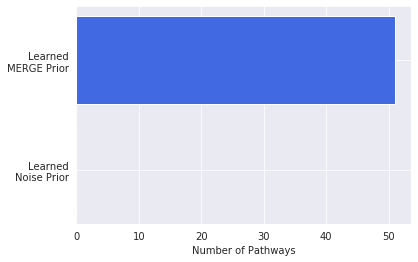

In [410]:
sns.set_style("darkgrid")

num_pathways_random_prior = len(enr_random_prior.results[enr_random_prior.results["Adjusted P-value"] < 0.05])
num_pathways_prior = len(enr_with_prior.results[enr_with_prior.results["Adjusted P-value"] < 0.05])

plt.barh(
    ["Learned\nNoise Prior", "Learned\nMERGE Prior"],
    [num_pathways_random_prior, num_pathways_prior],
    color=["seagreen", "royalblue"]
)

plt.xlabel("Number of Pathways")

In [415]:
enr_with_prior.results[enr_with_prior.results["Adjusted P-value"] < 0.05][["Adjusted P-value", "Term"]]

,Adjusted P-value,Term
0,0.000003,Hepatitis B
1,0.000010,AGE-RAGE signaling pathway in diabetic complications
2,0.000012,Th17 cell differentiation
3,0.000057,Leishmaniasis
4,0.000174,Transcriptional misregulation in cancer
5,0.000197,Inflammatory bowel disease (IBD)
6,0.000174,Th1 and Th2 cell differentiation
7,0.000230,Proteoglycans in cancer
8,0.000204,Viral carcinogenesis
9,0.000279,MAPK signaling pathway


# Partial Dependence Plots

In [435]:
merge_data.data.T.columns

Index(['Mutation', 'Expression hub', 'Regulator',
       'Genomic abnormalities (CNV)', 'meEthylation'],
      dtype='object')

In [490]:
def metafeature_pdp(
    metafeatures,
    feature_to_alter,
    meta_range,
    color,
    xlabel="Predicted Attribution Value",
    ylabel="Metafeature"
):
    meta_copy = metafeatures.copy()
    predicted_attributions_new_meta = []
    
    for new_meta_val in meta_range:
        meta_copy[feature_to_alter] = new_meta_val
        predicted_attributions_altered_feature = f2(torch.FloatTensor(meta_copy.values).cuda())
        predicted_attributions_new_meta.append(predicted_attributions_altered_feature.mean().item())
    plt.plot(meta_range, predicted_attributions_new_meta, color=color)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

In [498]:
methylation_vals = np.arange(0.0, 100, 1)
predicted_attributions_new_meth = []

for methylation_val in methylation_vals:
    prior_info_new_meth = prior_info.clone()
    prior_info_new_meth[:, 4] = methylation_val
    predicted_attributions_new_meth.append(f2(prior_info_new_meth).mean().item())

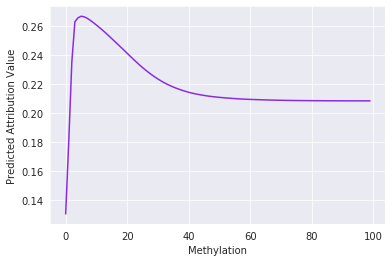

In [510]:
metafeature_pdp(
    metafeatures=merge_data.data.T,
    feature_to_alter="meEthylation",
    meta_range=range(0,100),
    color=colors["methylation"],
    xlabel="Methylation",
    ylabel="Predicted Attribution Value"
)

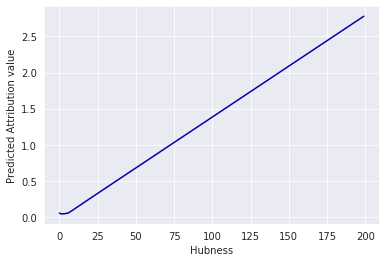

In [520]:
metafeature_pdp(
    metafeatures=merge_data.data.T,
    feature_to_alter="Expression hub",
    meta_range=range(0,200),
    color=colors["hubness"],
    xlabel="Hubness",
    ylabel="Predicted Attribution value"
)

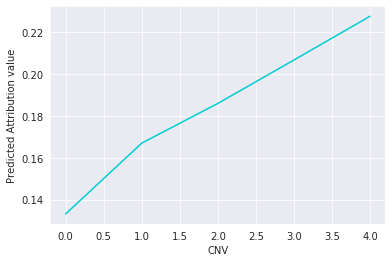

In [517]:
metafeature_pdp(
    metafeatures=merge_data.data.T,
    feature_to_alter="Genomic abnormalities (CNV)",
    meta_range=range(0,5),
    color=colors["cnv"],
    xlabel="CNV",
    ylabel="Predicted Attribution value"
)